Part A : Stock Market Prediction using ARIMA Model

In [3]:
import numpy as np 
import pandas as pd 
import os
from subprocess import check_output
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import yfinance as yf

In [4]:
#Downloading historical stock prices from yahoo finance
Sensex_Data =yf.download("^BSESN", start = '2001-01-01', end='2020-06-30')

[*********************100%***********************]  1 of 1 completed


In [5]:
Sensex_Data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


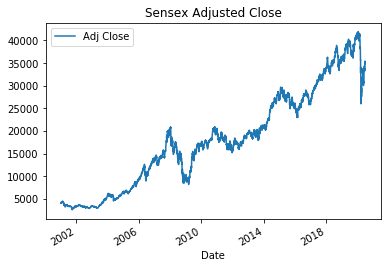

In [6]:
#Plotting the Adjusted close value
Sensex_Data[['Adj Close']].plot()
plt.title("Sensex Adjusted Close")
plt.show()

In [7]:
Sensex_Data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
Sensex_Data.reset_index(level=0, inplace=True)

In [9]:
Sensex_Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [10]:
#Checking distribuition of time series data across years
Sensex_Data['Date'].dt.year.value_counts()

2004    251
2010    250
2002    250
2003    250
2005    248
2017    248
2007    248
2006    247
2013    247
2001    247
2018    246
2011    246
2015    245
2016    245
2012    245
2008    244
2019    241
2014    240
2009    236
2020    120
Name: Date, dtype: int64

In [11]:
#Checking Null Values
Sensex_Data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
Sensex_Data.shape

(4794, 7)

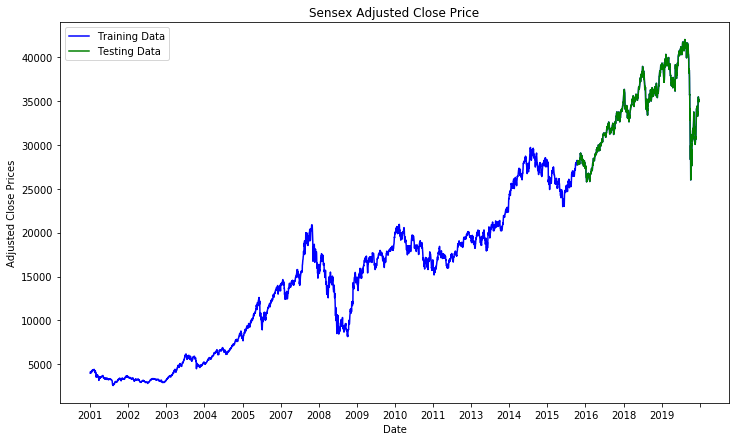

In [13]:
#Splitting into data into test & Training Set
train_data, test_data = Sensex_Data[0:int(len(Sensex_Data)*0.8)], Sensex_Data[int(len(Sensex_Data)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Sensex Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Prices')
plt.plot(Sensex_Data['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj Close'], 'green', label='Testing Data')
plt.xticks(np.arange(0,4838,300), Sensex_Data['Date'].dt.year[0:4838:300])
plt.legend()

In [14]:
train_data.shape, test_data.shape

((3835, 7), (959, 7))

Step 1: Performing adf test to check stationarity of time series data. If data is not stationary we have to perform log differencing to convert it to stationary

In [15]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [16]:
adfuller(train_data['Adj Close'])

(-0.2567284885753872,
 0.9314132169051644,
 5,
 3829,
 {'1%': -3.4320589812823554,
  '5%': -2.8622951341088414,
  '10%': -2.5671719675142097},
 51289.78163939323)

p value of 0.93 indicates that we have to accept our null hypothesis of data being non-stationary. In order to predict using ARIMA model, we have to transform our time series data through log differencing which should make resultant series stationary.

In [17]:
trainS=log(train_data['Adj Close']).diff()
adfuller(trainS[1:])

(-44.486641463283405,
 0.0,
 1,
 3832,
 {'1%': -3.4320576424555265,
  '5%': -2.862294542701668,
  '10%': -2.5671716526716017},
 -21199.277782214347)

In [18]:
testS=log(test_data['Adj Close']).diff()
adfuller(testS[1:])

(-7.703185094175135,
 1.3225714813389248e-11,
 13,
 944,
 {'1%': -3.4372961556318304,
  '5%': -2.864606557310281,
  '10%': -2.568402813173298},
 -5661.544647453682)

The Series is stationary now as confirmed by adf test with p-value < 0.05

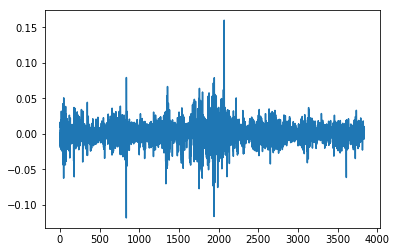

In [19]:
trainS.plot()

Step 2 : We have to identify the ideal value for AR(p) & MA(q) which can be fed into the ARIMA model through auto_arima function

In [20]:
from pyramid.arima import auto_arima

auto_arima Paratmeters : 

1) Trace :Whether to print status on the fits. A value of False will print no debugging information. A value of True will print some. 

2) error Action : controls the error-handling behavior.

3) stepwise : Whether to use the stepwise algorithm 

In [21]:
arima_model=auto_arima(trainS[1:],start_p=1,start_q=1,max_p=5,max_q=5,trace=True,error_action='warn',suppress_warnings=True,stepwise=True,random_state=20,n_fits=30)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21373.803, BIC=-21348.797, Fit time=9.912 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21342.991, BIC=-21330.487, Fit time=2.173 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21367.310, BIC=-21348.555, Fit time=0.813 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21370.367, BIC=-21351.612, Fit time=4.070 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21377.882, BIC=-21346.623, Fit time=5.631 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21378.879, BIC=-21353.873, Fit time=2.384 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21375.768, BIC=-21338.258, Fit time=7.093 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21377.769, BIC=-21346.511, Fit time=4.163 seconds
Total fit time: 36.972 seconds


In [22]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3834
Model:               SARIMAX(2, 0, 0)   Log Likelihood               10693.440
Date:                Sun, 25 Oct 2020   AIC                         -21378.879
Time:                        23:09:06   BIC                         -21353.873
Sample:                             0   HQIC                        -21369.996
                               - 3834                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.985      0.047    6.21e-06       0.001
ar.L1          0.0875      0.010      9.206      0.000       0.069       0.106
ar.L2         -0.0594      0.010     -5.679      0.000      -0.080      -0.039
sigma2         0.0002   2.33e-06     95.125      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       54.54   Jarque-Bera (JB):              9533.88
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Step3: Best model for our data is identified as (2,0,0) i.e AR=2, MA=0 & I=0 which will be fed into the ARIMA function to make predictions

In [23]:
#Making final predictions using ARIMA function
train_ar = trainS[1:].values
test_ar = testS[1:].values

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
print('Testing Mean Squared Error: %.5f' % mean_squared_error(test_ar, predictions))
print('Testing Mean Absolute Error: %.5f' % mean_absolute_error(test_ar, predictions))

<class 'list'>


C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Testing Mean Squared Error: 0.00015
Testing Mean Absolute Error: 0.00723


C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\pandas\core\indexes\range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


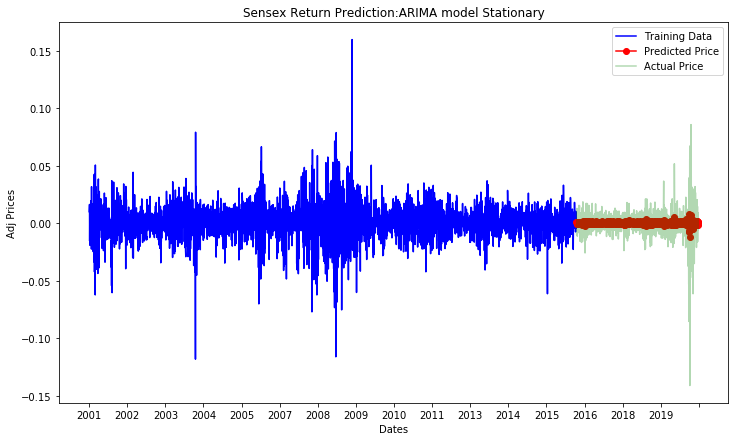

In [24]:
#Plotting the output
plt.figure(figsize=(12,7))
plt.plot(trainS[1:], 'green', color='blue', label='Training Data')
plt.plot(test_data.index[1:],predictions, color='red', marker='o',
         label='Predicted Price')
plt.plot(test_data.index[1:], testS[1:].values, color='green', label='Actual Price',alpha=0.3)
plt.title('Sensex Return Prediction:ARIMA model Stationary')
plt.xlabel('Dates')
plt.ylabel('Adj Prices')
plt.xticks(np.arange(0,4838,300), Sensex_Data['Date'].dt.year[0:4838:300])
plt.legend()

Final Step is to do data transformation of predicted return output to expected stock Adjusted closing price

In [25]:
testS[3835]=np.log(test_data['Adj Close'][3835])
ArimaModel=pd.DataFrame(np.exp(testS.cumsum()))
ArimaModel.rename(columns={'Adj Close': 'Y_Test'},inplace=True)

In [26]:
PredictedValue=[x.tolist() for x in predictions]
PredictedValue=[val for sublist in PredictedValue for val in sublist]
PredictedValue.insert(0,np.log(test_data['Adj Close'][3835]))
ArimaModel['ARIMA_Prediction']=PredictedValue
ArimaModel['ARIMA_Prediction']=pd.DataFrame(np.exp(ArimaModel['ARIMA_Prediction'].cumsum()))
ArimaModel.drop(ArimaModel.head(1).index, inplace=True)

C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


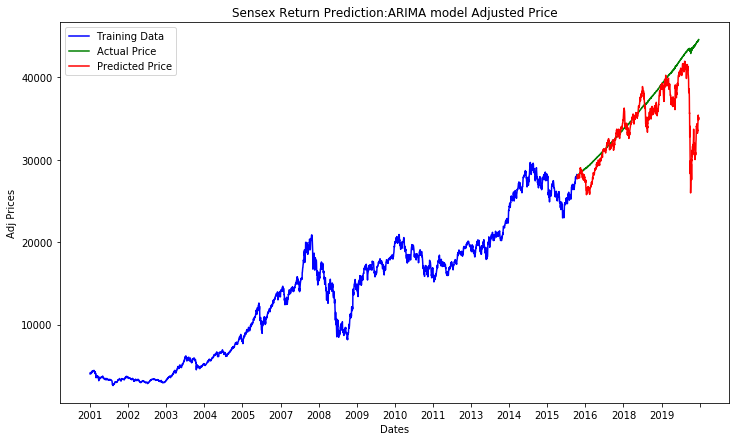

In [27]:
#plotting the final predicted Stock Price to the actual test data
plt.figure(figsize=(12,7))
plt.plot(train_data['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index[1:],ArimaModel['ARIMA_Prediction'], color='green', label='Actual Price')
plt.plot(test_data.index[1:], ArimaModel['Y_Test'].values, color='red', label='Predicted Price')
plt.title('Sensex Return Prediction:ARIMA model Adjusted Price')
plt.xlabel('Dates')
plt.ylabel('Adj Prices')
plt.xticks(np.arange(0,4838,300), Sensex_Data['Date'].dt.year[0:4838:300])
plt.legend()

In [28]:
ArimaModel.head(5)

,Y_Test,ARIMA_Prediction
3836,28003.119141,28078.987609
3837,27981.710937,28077.617311
3838,27697.509766,28092.483197
3839,27714.369141,28082.404112
3840,28078.349609,28114.724667


In [30]:
#ARIMA model mean squared error
print('RMSE: %.2f' % np.sqrt(mean_squared_error(ArimaModel['Y_Test'], ArimaModel['ARIMA_Prediction'])))

RMSE: 3735.14


In [31]:
#ARIMA model mean absolute error
print('MAE: %.2f' % mean_absolute_error(ArimaModel['Y_Test'], ArimaModel['ARIMA_Prediction']))

MAE: 2111.00


In [32]:
#Exporting the Arima Predictions to csv file which will be used in hybrid model.
ArimaModel['ARIMA_Prediction'].to_csv('ArimaPrediction.csv')